# <center>*IMPACT PROJECT - GESTAMP*</center> 
## <center>Defect Detection using Machine Learning</center> 
### <center>Multiclass Undersampling-Class Weights & RFECV</center>
_____

<img 
    src="https://www.gestamp.com/getattachment/c8d61c0f-e752-4156-8002-97e21ab43a3f/Imag2-2" width="2400" height="1000" align="center"/>

___

## <center>*Table of Contents*</center>
1. [Final Dataset Preparation](#1)
2. [Random Forest](#2)
    * 2.1. [GridSearch & RFECV](#2.1)
    * 2.2. [Evaluation](#2.2)
    * 2.3. [Confusion Matrix](#2.3)
    * 2.4. [Classification Report](#2.4)
    * 2.5. [Feature Importance](#2.5)
3. [KNN](#3)
    * 3.1. [GridSearch & RFECV](#3.1)
    * 3.2. [Evaluation](#3.2)
    * 3.3. [Confusion Matrix](#3.3)
    * 3.4. [Classification Report](#3.4)
4. [XGBoost](#4)
    * 4.1. [GridSearch & RFECV](#4.1)
    * 4.2. [Evaluation](#4.2)
    * 4.3. [Confusion Matrix](#4.3)
    * 4.4. [Classification Report](#4.4)
    * 4.5. [Feature Importance](#4.5)
5. [Extra Trees](#5)
    * 5.1. [GridSearch & RFECV](#5.1)
    * 5.2. [Evaluation](#5.2)
    * 5.3. [Confusion Matrix](#5.3)
    * 5.4. [Classification Report](#5.4)
    * 5.5. [Feature Importance](#5.5)
6. [Voting Classifier](#6)
    * 6.1. [GridSearch & RFECV](#6.1)
    * 6.2. [Evaluation](#6.2)
    * 6.3. [Confusion Matrix](#6.3)
    * 6.4. [Classification Report](#6.4)



## Final Dataset Preparation <a id='1'></a>

In [45]:
#Import necessary libraries
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
from sklearn.ensemble import VotingClassifier

Dataset used for this analysis gotten from EDA notebooks, dataset with `Iterative Imputer` + `Standard Scaling`

In [46]:
# Import csv
final_df = pd.read_csv('final_df_2.csv')

In [47]:
# Verify Original Defect Classes
final_df['Defect'].value_counts()

0                      118493
0                       24940
marks/contamination        86
deformation                66
marks                      35
thinning                   33
waves                      23
meterial failure           22
cracks                     20
scratch                     4
dent                        2
Name: Defect, dtype: int64

In [48]:
# Standardize Defect Classes
final_df['Defect'] = final_df['Defect'].replace(0 , '0')

In [49]:
final_df['Defect'].value_counts()

0                      143433
marks/contamination        86
deformation                66
marks                      35
thinning                   33
waves                      23
meterial failure           22
cracks                     20
scratch                     4
dent                        2
Name: Defect, dtype: int64

In [50]:
final_df['Defect'].value_counts()

0                      143433
marks/contamination        86
deformation                66
marks                      35
thinning                   33
waves                      23
meterial failure           22
cracks                     20
scratch                     4
dent                        2
Name: Defect, dtype: int64

In [51]:
# Define the mapping for grouping the defects
defect_mapping = {
    'deformation': 2,
    'thinning': 2,
    'meterial failure': 2,
    'marks': 1,
    'marks/contamination': 1,
    'scratch': 1,
    'dent': 1,
    'cracks': 3,
    'waves': 3,
    '0': 0
}
# Create a new column 'Defect_Group' based on the mapping
final_df['Defect_Group'] = final_df['Defect'].replace(defect_mapping)

# Drop the original 'Defects' column if desired
final_df.drop(['Defect', 'Unnamed: 0', 'TraceabilityCode'], axis=1, inplace=True)

In [52]:
final_df['Defect_Group'].value_counts()

0    143433
1       127
2       121
3        43
Name: Defect_Group, dtype: int64

In [53]:
# Defining X and y
X = final_df.drop('Defect_Group', axis=1)
y = final_df['Defect_Group']

In [56]:
# split
X_train1, X_test, y_train1, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.7, 
                                                    stratify=y)

undersampler = RandomUnderSampler(sampling_strategy={0: 291})
X_train, y_train = undersampler.fit_resample(X_train1, y_train1)


## Random Forest <a id='2'></a>

### Random Forest GridSearch & RFECV <a id='2.1'></a>

In [57]:
# Create a Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced')

# Define the hyperparameter grid for the random forest classifier
param_grid_rf = {
    'n_estimators': [50, 75, 100],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None]
}

# Create an instance of RFECV with the random forest classifier
rfecv_rf = RFECV(estimator=rf_model, cv=5, scoring='accuracy')

# Fit the RFECV object to your training data
rfecv_rf.fit(X_train, y_train)

# Get the selected features
selected_features_rf = X_train.columns[rfecv_rf.support_]

# Create a new dataset with selected features
X_train_selected_rf = X_train[selected_features_rf]
X_test_selected_rf = X_test[selected_features_rf]

# Create a GridSearchCV object
grid_rf = GridSearchCV(rf_model, param_grid=param_grid_rf, scoring='accuracy', cv=5)

# Fit the GridSearchCV object using the selected features
grid_rf.fit(X_train_selected_rf, y_train)

# Print the best parameters
print(grid_rf.best_params_)

# Get the best estimator
best_rf_model = grid_rf.best_estimator_


{'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 75}


### Random Forest Evaluation <a id='2.2'></a>

In [59]:
# Make predictions on the training set
y_train_pred_rf = best_rf_model.predict(X_train_selected_rf)
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)

# Make predictions on the test set
y_test_pred_rf = best_rf_model.predict(X_test_selected_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print("Training Accuracy score:", train_acc_rf)
print("Test Accuracy score:", test_acc_rf)

Training Accuracy score: 0.9777777777777777
Test Accuracy score: 0.8363096618581567


### Random Forest Confusion Matrix <a id='2.3'></a>

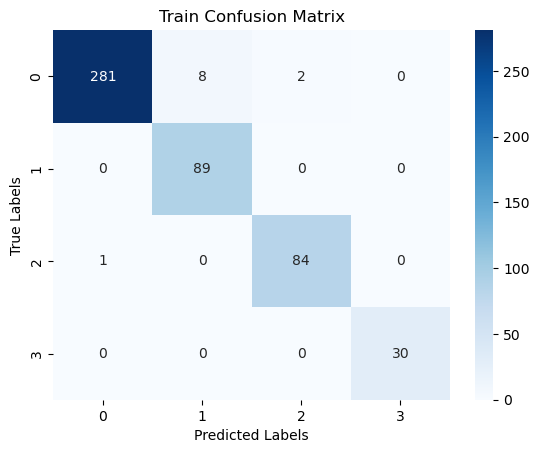

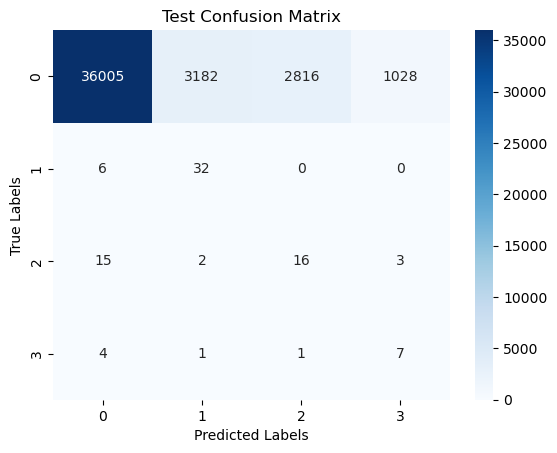

In [60]:
# Plot confusion matrix

cm_train = confusion_matrix(y_train, y_train_pred_rf)
cm_test = confusion_matrix(y_test, y_test_pred_rf)

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Random Forest Classification Report <a id='2.4'></a>

In [61]:
# Classification Report
report = classification_report(y_test, y_test_pred_rf)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     43031
           1       0.01      0.84      0.02        38
           2       0.01      0.44      0.01        36
           3       0.01      0.54      0.01        13

    accuracy                           0.84     43118
   macro avg       0.26      0.67      0.24     43118
weighted avg       1.00      0.84      0.91     43118



### Random Forest Feature Importance <a id='2.5'></a>

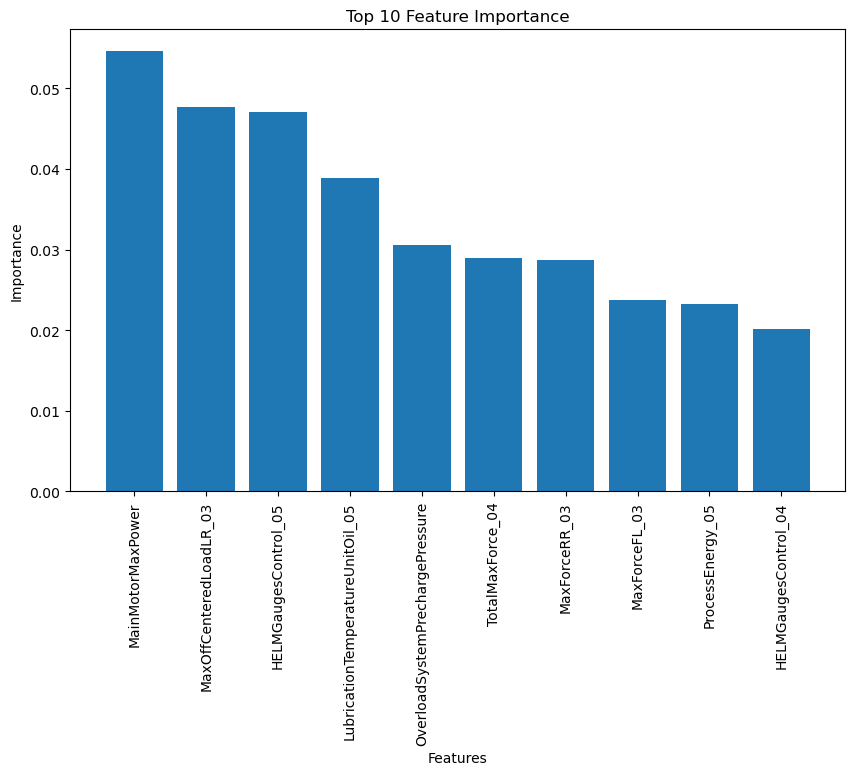

In [62]:
# Plotting Feature Importance
feature_importance = best_rf_model.feature_importances_
features = X_train_selected_rf.columns

# Sort the feature importance in descending order
indices = np.argsort(feature_importance)[::-1]

# Select the top 10 features
top_features = features[indices][:10]
top_importance = feature_importance[indices][:10]

plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importance)
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## K Nearest Neighbors  <a id='3'></a>

### KNN GridSearch & RFECV <a id='3.1'></a>

In [63]:
# create a KNN Classifier
knn_model = KNeighborsClassifier()

# define the hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# create a GridSearchCV object
grid_knn = GridSearchCV(knn_model, param_grid=param_grid_knn, scoring='accuracy', cv=5)

grid_knn.fit(X_train, y_train)

print(grid_knn.best_params_)
best_knn_model = grid_knn.best_estimator_

{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}


### KNN Evaluation <a id='3.2'></a>

In [64]:
# Make predictions on the training set
y_train_pred_knn = best_knn_model.predict(X_train)
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)

# Make predictions on the test set
y_test_pred_knn = best_knn_model.predict(X_test)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)

print("Training Accuracy score:", train_acc_knn)
print("Test Accuracy score:", test_acc_knn)

Training Accuracy score: 1.0
Test Accuracy score: 0.8069483742288603


### KNN Confusion Matrix <a id='3.3'></a>

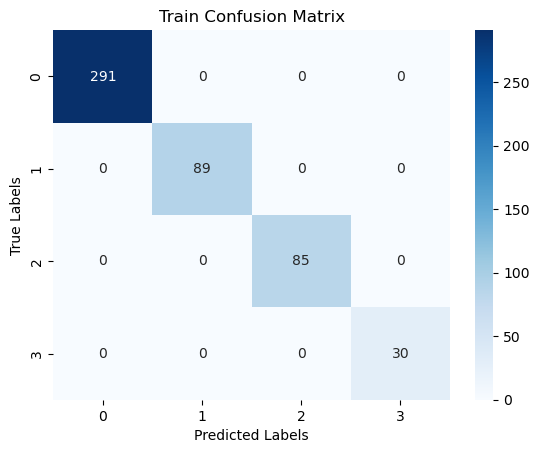

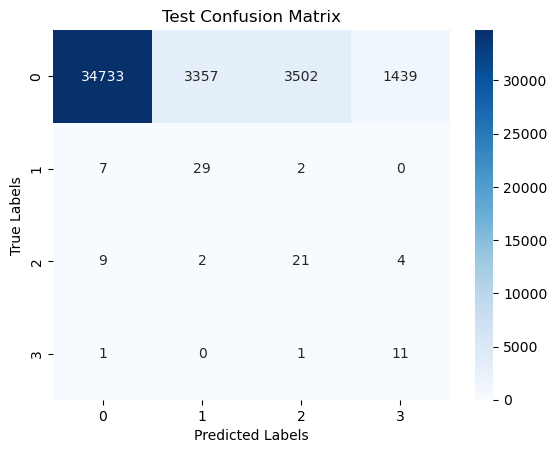

In [65]:
#plot confusion matrix

cm_train_knn = confusion_matrix(y_train, y_train_pred_knn)
cm_test_knn = confusion_matrix(y_test, y_test_pred_knn)

sns.heatmap(cm_train_knn, annot=True, fmt="d", cmap="Blues")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

sns.heatmap(cm_test_knn, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### KNN Classification Report <a id='3.4'></a>

In [66]:
# Classification Report
report = classification_report(y_test, y_test_pred_knn)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     43031
           1       0.01      0.76      0.02        38
           2       0.01      0.58      0.01        36
           3       0.01      0.85      0.01        13

    accuracy                           0.81     43118
   macro avg       0.26      0.75      0.23     43118
weighted avg       1.00      0.81      0.89     43118



## XGBoost <a id='4'></a>

### XGB GridSearch & RFECV <a id='4.1'></a>

In [67]:
# Create an XGB Classifier
xgb_model = XGBClassifier()

# Define the hyperparameter grid for XGB
param_grid_xgb = {
    'n_estimators': [50, 75, 100],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create an instance of RFECV with XGB
rfecv_xgb = RFECV(estimator=xgb_model, cv=5, scoring='accuracy')

# Fit RFECV to your training data
rfecv_xgb.fit(X_train, y_train)

# Get the selected features
selected_features_xgb = X_train.columns[rfecv_xgb.support_]

# Create a new dataset with selected features
X_train_selected_xgb = X_train[selected_features_xgb]
X_test_selected_xgb = X_test[selected_features_xgb]

# Create a GridSearchCV object
grid_xgb = GridSearchCV(xgb_model, param_grid=param_grid_xgb, scoring='accuracy', cv=5)

# Fit the GridSearchCV object using the selected features
grid_xgb.fit(X_train_selected_xgb, y_train)

# Print the best parameters
print(grid_xgb.best_params_)

# Get the best estimator
best_xgb_model = grid_xgb.best_estimator_

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


### XGB Evaluation <a id='4.2'></a>

In [68]:
# Make predictions on the training set
y_train_pred_xgb = best_xgb_model.predict(X_train_selected_xgb)
train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)

# Make predictions on the test set
y_test_pred_xgb = best_xgb_model.predict(X_test_selected_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print("Training Accuracy score:", train_acc_xgb)
print("Test Accuracy score:", test_acc_xgb)

Training Accuracy score: 1.0
Test Accuracy score: 0.8873556287397375


### XGB Confusion Matrix <a id='4.3'></a>

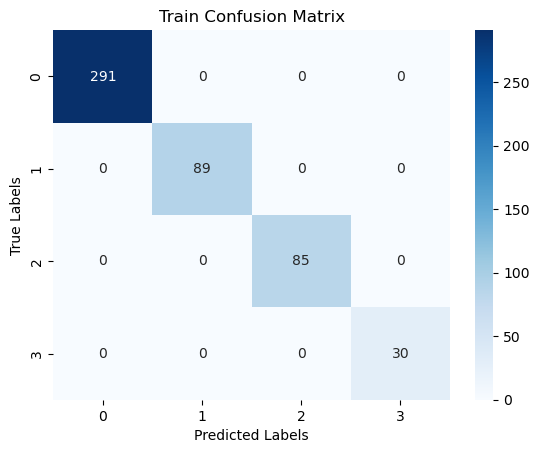

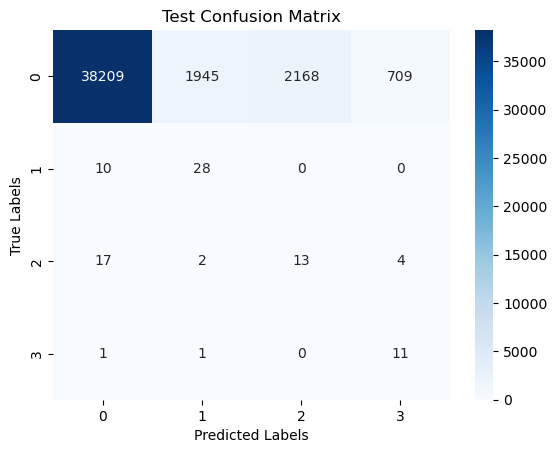

In [69]:
#plot Confusion Matrix

cm_train_xgb = confusion_matrix(y_train, y_train_pred_xgb)
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)

sns.heatmap(cm_train_xgb, annot=True, fmt="d", cmap="Blues")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

sns.heatmap(cm_test_xgb, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### XGB Classification Report <a id='4.4'></a>

In [70]:
# Classification Report
report = classification_report(y_test, y_test_pred_xgb)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     43031
           1       0.01      0.74      0.03        38
           2       0.01      0.36      0.01        36
           3       0.02      0.85      0.03        13

    accuracy                           0.89     43118
   macro avg       0.26      0.71      0.25     43118
weighted avg       1.00      0.89      0.94     43118



### XGB Feature Importance <a id='4.5'></a>

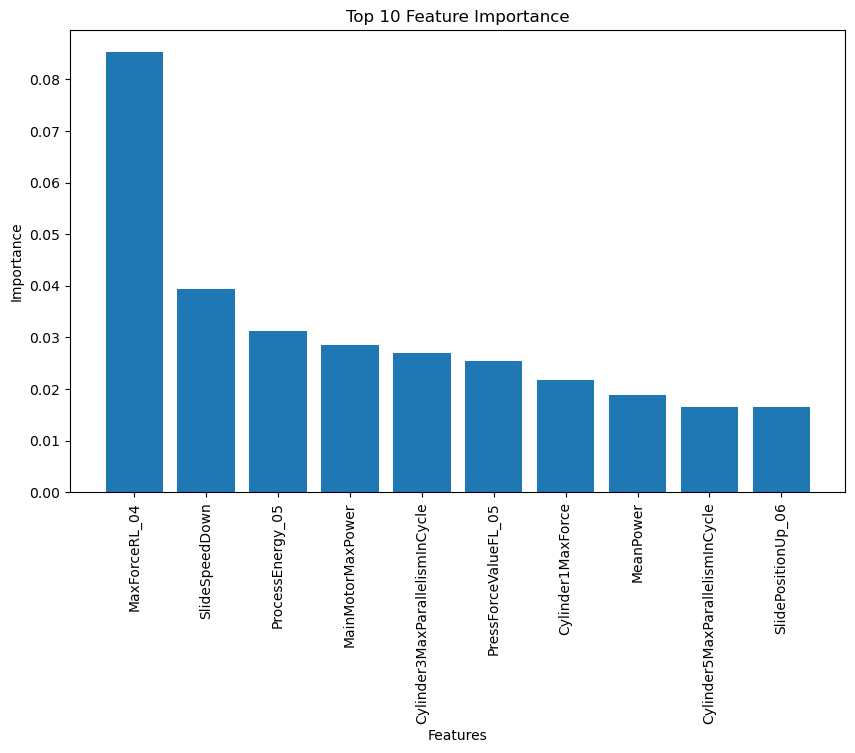

In [71]:
# Plotting Feature Importance
feature_importance = best_xgb_model.feature_importances_
features = X_train_selected_xgb.columns

# Sort the feature importance in descending order
indices = np.argsort(feature_importance)[::-1]

# Select the top 10 features
top_features = features[indices][:10]
top_importance = feature_importance[indices][:10]

plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importance)
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## Extra Trees Classifier <a id='5'></a>

### Extra Trees GridSearch & RFECV <a id='5.1'></a>

In [72]:
# Create an Extra Trees Classifier
et_model = ExtraTreesClassifier(class_weight='balanced')

# Define the hyperparameter grid for Extra Trees
param_grid_et = {
    'n_estimators': [50, 75, 100],
    'max_depth': [5, 7, 9],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create an instance of RFECV with Extra Trees
rfecv_et = RFECV(estimator=et_model, cv=5, scoring='accuracy')

# Fit RFECV to your training data
rfecv_et.fit(X_train, y_train)

# Get the selected features
selected_features_et = X_train.columns[rfecv_et.support_]

# Create a new dataset with selected features
X_train_selected_et = X_train[selected_features_et]
X_test_selected_et = X_test[selected_features_et]

# Create a GridSearchCV object
grid_et = GridSearchCV(et_model, param_grid=param_grid_et, scoring='accuracy', cv=5)

# Fit the GridSearchCV object using the selected features
grid_et.fit(X_train_selected_et, y_train)

# Print the best parameters
print(grid_et.best_params_)

# Get the best estimator
best_et_model = grid_et.best_estimator_

{'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### Extra Trees Evaluation <a id='5.2'></a>

In [74]:
# Make predictions on the training set
y_train_pred_et = best_et_model.predict(X_train_selected_et)
train_acc_et = accuracy_score(y_train, y_train_pred_et)

# Make predictions on the test set
y_test_pred_et = best_et_model.predict(X_test_selected_et)
test_acc_et = accuracy_score(y_test, y_test_pred_et)

print("Training Accuracy score:", train_acc_et)
print("Test Accuracy score:", test_acc_et)

Training Accuracy score: 0.9171717171717172
Test Accuracy score: 0.7300431374368014


### Extra Trees Confusion Matrix <a id='5.3'></a>

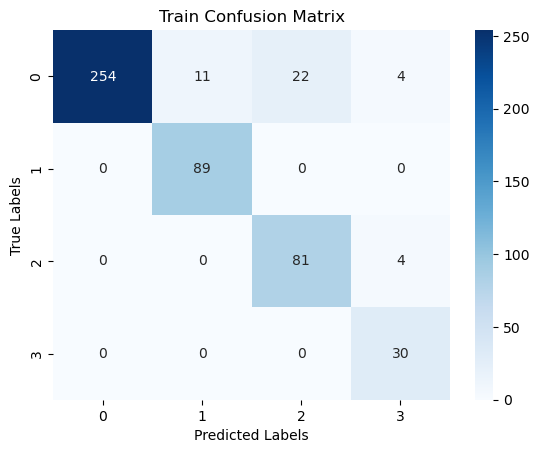

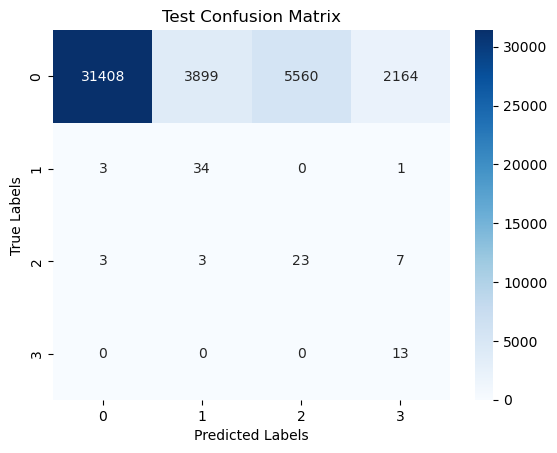

In [75]:
#plot Confusion Matrix

cm_train_et = confusion_matrix(y_train, y_train_pred_et)
cm_test_et = confusion_matrix(y_test, y_test_pred_et)

sns.heatmap(cm_train_et, annot=True, fmt="d", cmap="Blues")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

sns.heatmap(cm_test_et, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### ET Classification Report <a id='5.4'></a>

In [76]:
# Classification Report
report_et = classification_report(y_test, y_test_pred_et)
print(report_et)

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     43031
           1       0.01      0.89      0.02        38
           2       0.00      0.64      0.01        36
           3       0.01      1.00      0.01        13

    accuracy                           0.73     43118
   macro avg       0.25      0.82      0.22     43118
weighted avg       1.00      0.73      0.84     43118



#### ET Feature Importance <a id='5.5'></a>

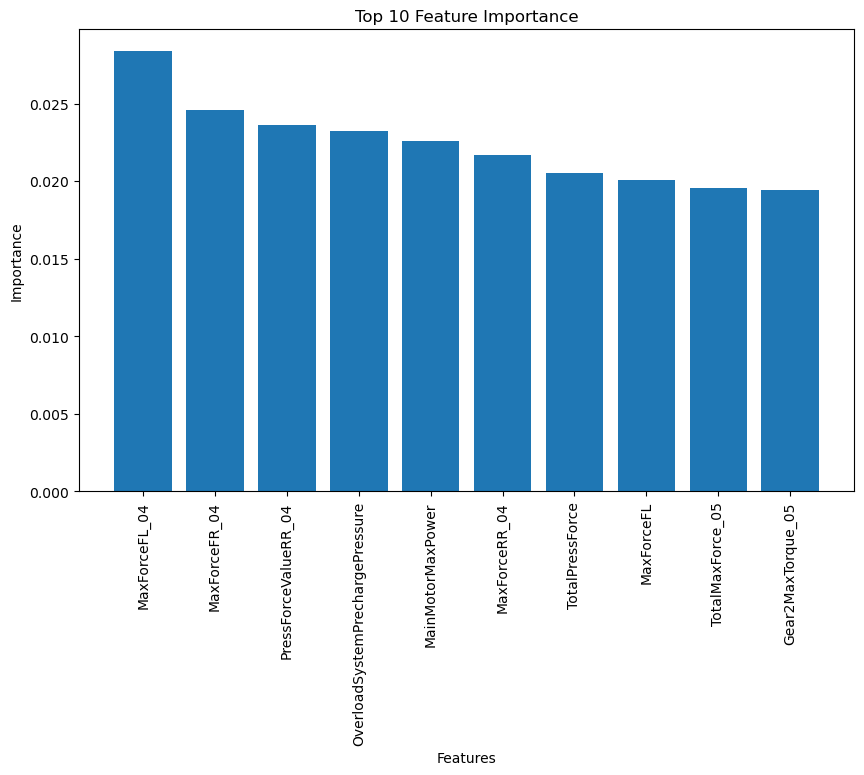

In [77]:
# Plotting Feature Importance
feature_importance = best_et_model.feature_importances_
features = X_train_selected_et.columns

# Sort the feature importance in descending order
indices = np.argsort(feature_importance)[::-1]

# Select the top 10 features
top_features = features[indices][:10]
top_importance = feature_importance[indices][:10]

plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importance)
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## Voting Classifier <a id='6'></a>

### Voting Classifier Training <a id='6.1'></a>

In [85]:
# Create the VotingClassifier
voting_classifier = VotingClassifier(
    estimators=[ ('rf', best_rf_model), ('et', best_et_model) ],
    voting='hard' 

# Train the VotingClassifier
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=9,
                                                     max_features=None,
                                                     min_samples_split=7,
                                                     n_estimators=75)),
                             ('et',
                              ExtraTreesClassifier(class_weight='balanced',
                                                   max_depth=9,
                                                   max_features='log2'))])

### Voting Classifier Evaluation <a id='6.2'></a>

In [86]:
# Make predictions using the VotingClassifier
y_train_pred_voting = voting_classifier.predict(X_train)
y_test_pred_voting = voting_classifier.predict(X_test)

train_acc_voting = accuracy_score(y_train, y_train_pred_voting)
test_acc_voting = accuracy_score(y_test, y_test_pred_voting)
print("Training Accuracy score:", train_acc_voting)
print("Test Accuracy score:", test_acc_voting)

Training Accuracy score: 0.9919191919191919
Test Accuracy score: 0.8452154552623035


### Voting Classifier Confusion Matrix <a id='6.3'></a>

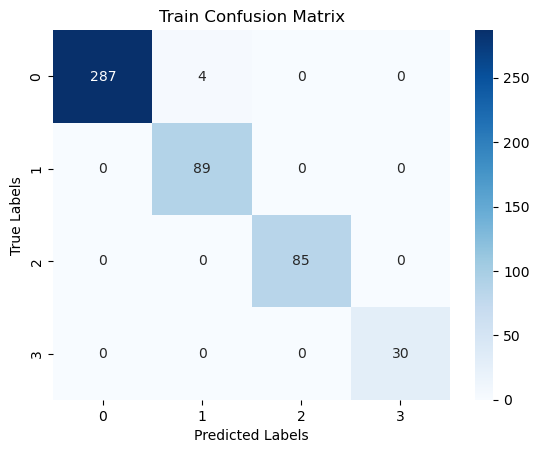

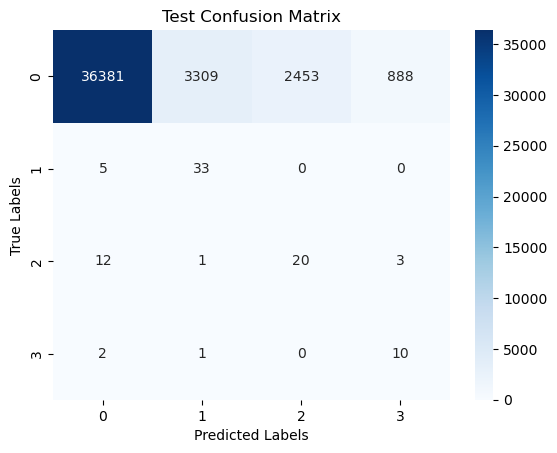

In [88]:
#plot Confusion Matrix
cm_train_voting = confusion_matrix(y_train, y_train_pred_voting)
cm_test_voting = confusion_matrix(y_test, y_test_pred_voting)

sns.heatmap(cm_train_voting, annot=True, fmt="d", cmap="Blues")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

sns.heatmap(cm_test_voting, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Voting Classifier Classification Report <a id='6.4'></a>

In [87]:
# Classification Report
report_voting = classification_report(y_test, y_test_pred_voting)
print(report_voting)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     43031
           1       0.01      0.87      0.02        38
           2       0.01      0.56      0.02        36
           3       0.01      0.77      0.02        13

    accuracy                           0.85     43118
   macro avg       0.26      0.76      0.24     43118
weighted avg       1.00      0.85      0.91     43118

